In [2]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%qtconsole --colors=linux
plt.style.use('ggplot')

from matplotlib import gridspec
from theano import tensor as tt
from scipy import stats

# Chapter 9 - Comparing binomial rates
## 9.1 Equality of proportions


$$ s_{1} \sim \text{Binomial}(\theta_{1},n_{1})$$
$$ s_{2} \sim \text{Binomial}(\theta_{2},n_{2})$$
$$ \theta_{1} \sim \text{Beta}(1,1) $$
$$ \theta_{2} \sim \text{Beta}(1,1) $$
$$ \delta = \theta_{1} -\theta_{2}$$ 

In [9]:
# pledger data:
s1 = 424
s2 = 5416
n1 = 777
n2 = 9072

# two-sided p-value = 0.005848:
pledger = np.array([[s1,s2], [n1-s1, n2-s2]])
chi2, p, dof, ex =stats.chi2_contingency(pledger) 
print('The two-sided p-value is %.5f' % (p))
# Analytical Bayes factor:
from scipy.special import gammaln
def lchoose(N, k):
    return gammaln(N+1) - gammaln(N-k+1) - gammaln(k+1)
logBF01 = [lchoose(n1, s1) + lchoose(n2, s2) + np.log(n1 + 1) + np.log(n2 + 1)
           - lchoose(n1+n2, s1+s2) - np.log(n1 + n2 + 1)]
BF01 = np.exp(logBF01[0])
print('The analytical Bayes factor is %.5f' % (BF01))

The two-sided p-value is 0.00585
The analytical Bayes factor is 0.44974


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -15.791: 100%|██████████| 200000/200000 [00:10<00:00, 18700.84it/s]
Finished [100%]: Average ELBO = -15.788
100%|██████████| 3000/3000.0 [00:01<00:00, 2203.91it/s]


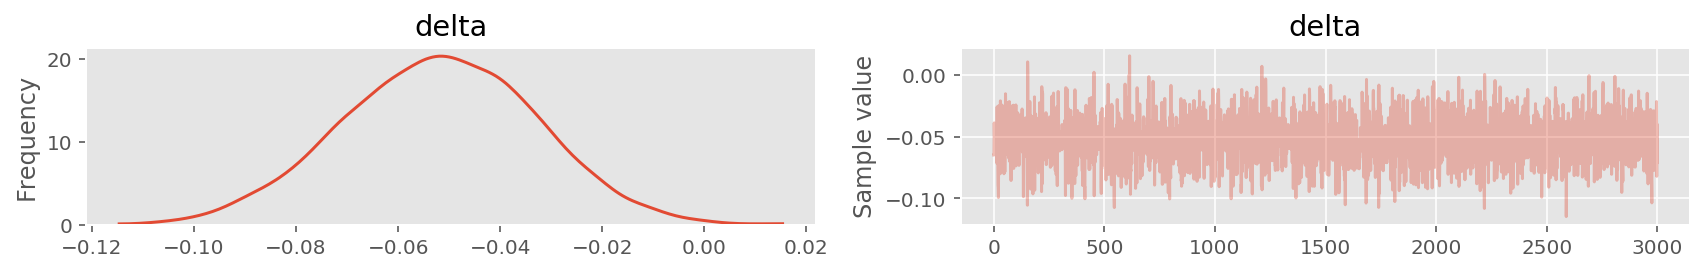

In [10]:
with pm.Model() as model1:
    theta1 = pm.Beta('theta1', alpha=1, beta=1)
    theta2 = pm.Beta('theta2', alpha=1, beta=1)
    delta = pm.Deterministic('delta', theta1-theta2)
    
    s1 = pm.Binomial('s1', p=theta1, n=n1, observed=s1)
    s2 = pm.Binomial('s2', p=theta2, n=n2, observed=s2)
    trace1=pm.sample(3e3, model=model1)

burnin = 0    
pm.traceplot(trace1[burnin:], varnames=['delta']);
plt.show()


delta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -0.052           0.019            0.000            [-0.091, -0.018]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.090         -0.065         -0.052         -0.039         -0.015

the Bayes Factor is 1.48530


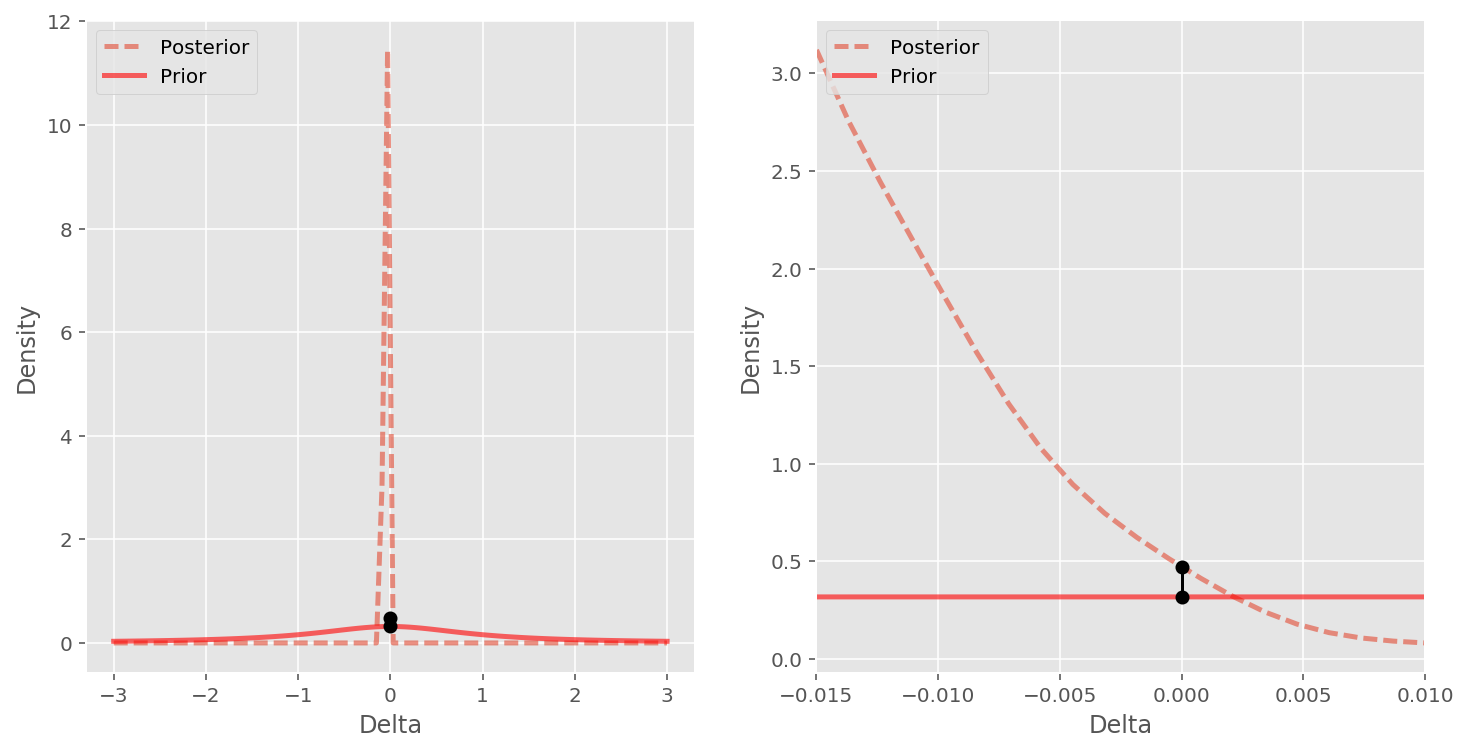

In [11]:
# BFs based on density estimation (using kernel smoothing instead of spline)
from scipy.stats.kde import gaussian_kde
from scipy.stats import cauchy

pm.summary(trace1, varnames=['delta'])
tmp = pm.df_summary(trace1, varnames=['delta'])
# 95% confidence interval:
x0 = tmp.values[0, 3]
x1 = tmp.values[0, 4]

fig = plt.figure(figsize=(12, 6)) 
gs = gridspec.GridSpec(1, 2) 
ax1 = plt.subplot(gs[0])
t_delt = trace1['delta'][:]
my_pdf = gaussian_kde(t_delt)
x = np.linspace(-3, 3, 100)
ax1.plot(x, my_pdf(x), '--', lw=2.5, alpha=0.6, label='Posterior') # distribution function
ax1.plot(x, cauchy.pdf(x), 'r-', lw=2.5, alpha=0.6, label='Prior')
posterior = my_pdf(0)             # this gives the pdf at point delta = 0
prior     = cauchy.pdf(0)         # height of order-restricted prior at delta = 0
BF01      = posterior/prior
print ('the Bayes Factor is %.5f' % (BF01))
ax1.plot([0, 0], [posterior, prior], 'k-', 
         [0, 0], [posterior, prior], 'ko', 
         lw=1.5, alpha=1)
plt.xlabel('Delta')
plt.ylabel('Density')
plt.legend(loc='upper left')

ax2 = plt.subplot(gs[1])
x = np.linspace(-.015, .01, 20)
ax2.plot(x, my_pdf(x), '--', lw=2.5, alpha=0.6, label='Posterior') # distribution function
ax2.plot(x, cauchy.pdf(x), 'r-', lw=2.5, alpha=0.6, label='Prior')
ax2.plot([0, 0], [posterior, prior], 'k-', 
         [0, 0], [posterior, prior], 'ko', 
         lw=1.5, alpha=1)
plt.xlabel('Delta')
plt.ylabel('Density')
plt.legend(loc='upper left')
plt.xlim([-.015, .01])
plt.show()

## 9.2 Order-restricted equality of proportions


$$ s_{1} \sim \text{Binomial}(\theta_{1},n_{1})$$
$$ s_{2} \sim \text{Binomial}(\theta_{2},n_{2})$$
$$ (\theta_{1},\theta_{2}) \sim \text{Uniform}(0,1)^2, \theta_{2} \gt \theta_{1}$$
$$ \delta = \theta_{1} -\theta_{2}$$ 

THe order-restriction of the parameter $\delta < 0$ requires $ \theta_{2} \gt \theta_{1}$. It was address previously in the book by using ```theta2 ~ dunif(0,1)``` and ```theta1 ~ dunif(0,theta2)```. However, doing so introduce a bias in the prior:

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -0.048706: 100%|██████████| 200000/200000 [00:08<00:00, 22637.84it/s]
Finished [100%]: Average ELBO = -0.039138
Evidence of divergence detected, inspect ELBO.
100%|██████████| 10000/10000.0 [00:04<00:00, 2223.72it/s]


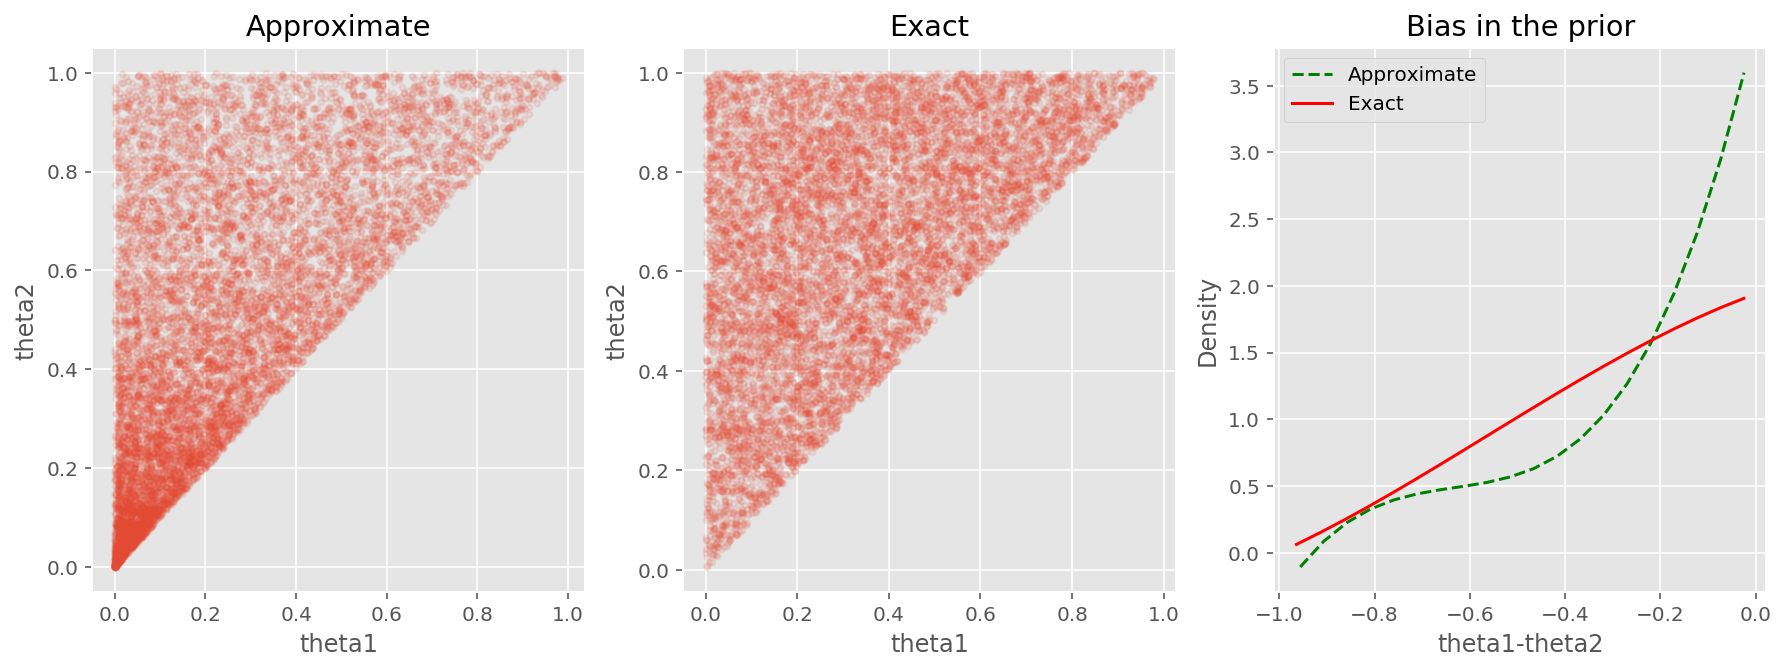

In [14]:
with pm.Model() as modelAE:
    # the Approximate method
    theta2a = pm.Uniform('theta2a', lower=0, upper=1)
    theta1a = pm.Uniform('theta1a', lower=0, upper=theta2a)
    deltaa = pm.Deterministic('deltaa', theta1a-theta2a)
    
    ## the Exact method
    # Adaptation of the exact method as in the book using joint samples from a
    # bivariate standard Gaussian then rotating them by 45 degree. The rotated
    # sample is transform tinto rates that lie in the unit square
    thetap = pm.MvNormal('thetap', mu=[0, 0], tau=pm.math.constant(np.eye(2)), shape=2)
    
    def phi(x):
        #'Cumulative distribution function for the standard normal distribution'
        return (1.0 + tt.erf(x / np.sqrt(2.0))) / 2.0

    def normcdf1(thetap1, thetap2):
        angle = 45*np.pi/180
        return phi((np.cos(angle) * thetap1) - (np.sin(angle) * abs(thetap2)))
    theta1e = pm.Deterministic('theta1e', normcdf1(thetap[0], thetap[1]))
    
    def normcdf2(thetap1, thetap2):
        angle = 45*np.pi/180
        return phi((np.sin(angle) * thetap1) + (np.cos(angle) * abs(thetap2)))
    theta2e = pm.Deterministic('theta2e', normcdf2(thetap[0], thetap[1]))
    
    deltae = pm.Deterministic('deltae', theta1e-theta2e)

    traceAE=pm.sample(1e4, model=modelAE)
    
fig = plt.figure(figsize=(15, 5)) 
gs = gridspec.GridSpec(1, 3) 
ax1 = plt.subplot(gs[0])
ax1.plot(traceAE['theta1a'][:], traceAE['theta2a'][:], '.', alpha=.1)
plt.xlabel('theta1')
plt.ylabel('theta2')
plt.title('Approximate')

ax2 = plt.subplot(gs[1])
ax2.plot(traceAE['theta1e'][:], traceAE['theta2e'][:], '.', alpha=.1)
plt.xlabel('theta1')
plt.ylabel('theta2')
plt.title('Exact')

from scipy.interpolate import UnivariateSpline
ax2 = plt.subplot(gs[2])
y, binEdges = np.histogram(traceAE['deltaa'][:], bins=20, normed=True)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
s = UnivariateSpline(bincenters, y, s=1)
ax2.plot(bincenters,s(bincenters), 'g--', label='Approximate')

y2,binEdges2=np.histogram(traceAE['deltae'][:], bins=20, normed=True)
bincenters2 = 0.5*(binEdges2[1:]+binEdges2[:-1])
s2 = UnivariateSpline(bincenters2, y2, s=1)
ax2.plot(bincenters2, s2(bincenters2), 'r-', label='Exact')

plt.xlabel('theta1-theta2')
plt.ylabel('Density')
plt.title('Bias in the prior')
plt.legend(loc='upper left')
plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -17.653: 100%|██████████| 200000/200000 [00:10<00:00, 19063.85it/s]
Finished [100%]: Average ELBO = -17.659
100%|██████████| 10000/10000.0 [00:13<00:00, 755.06it/s]


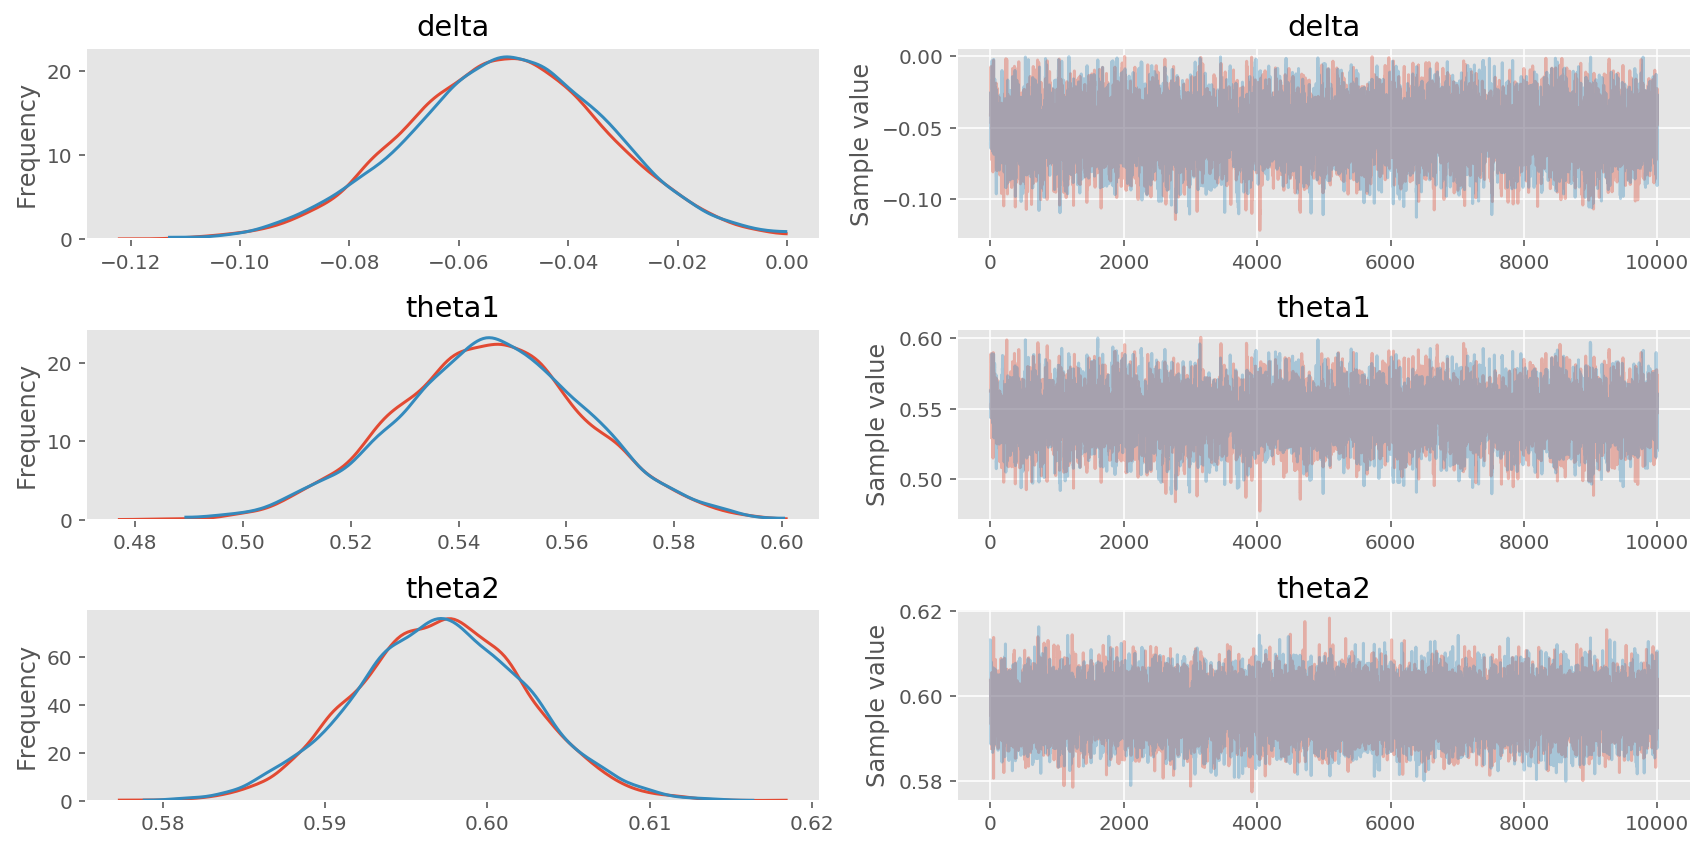

In [15]:
# pledger data:
s1 = 424
s2 = 5416
n1 = 777
n2 = 9072

with pm.Model() as model2:
    ## the Exact method
    # Adaptation of the exact method as in the book using joint samples from a
    # bivariate standard Gaussian then rotating them by 45 degree. The rotated
    # sample is transform tinto rates that lie in the unit square
    thetap = pm.MvNormal('thetap', mu=[0, 0], tau= pm.math.constant(np.eye(2)), shape=2)
    def phi(x):
        #'Cumulative distribution function for the standard normal distribution'
        # Also it is the probit transform 
        return (1.0 + tt.erf(x / np.sqrt(2.0))) / 2.0

    def normcdf1(thetap1, thetap2):
        angle = 45*np.pi/180
        return phi((np.cos(angle) * thetap1) - (np.sin(angle) * abs(thetap2)))
    theta1 = pm.Deterministic('theta1', normcdf1(thetap[0], thetap[1]))
    
    def normcdf2(thetap1, thetap2):
        angle = 45*np.pi/180
        return phi((np.sin(angle) * thetap1) + (np.cos(angle) * abs(thetap2)))
    theta2 = pm.Deterministic('theta2', normcdf2(thetap[0], thetap[1]))

    ## the Approximate method
    # theta2 = pm.Uniform("theta2",lower=0,upper=1)
    # theta1 = pm.Uniform("theta1",lower=0,upper=theta2)
    
    delta = pm.Deterministic('delta', theta1-theta2)
    
    so1 = pm.Binomial('so1', p=theta1, n=n1, observed=s1)
    so2 = pm.Binomial('so2', p=theta2, n=n2, observed=s2)
    
    trace2 = pm.sample(1e4, njobs=2)

burnin=0    
pm.traceplot(trace2[burnin:], varnames=['delta', 'theta1', 'theta2']);
plt.show()


delta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -0.052           0.018            0.000            [-0.088, -0.016]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.088         -0.064         -0.051         -0.039         -0.016

the Bayes Factor is 1.48530


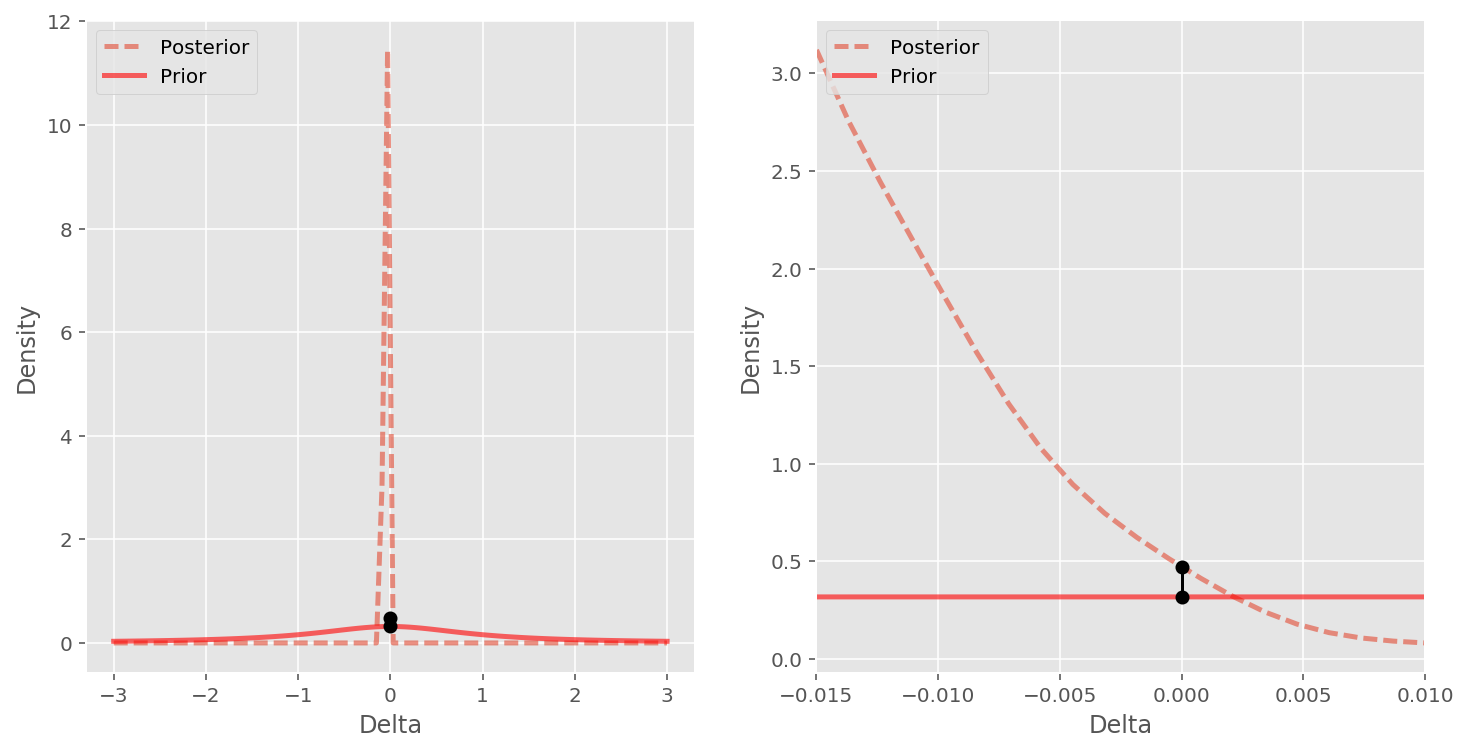

In [16]:
pm.summary(trace2, varnames=['delta'])
tmp = pm.df_summary(trace2, varnames=['delta'])
# 95% confidence interval:
x0 = tmp.values[0, 3]
x1 = tmp.values[0, 4]

fig = plt.figure(figsize=(12, 6)) 
gs = gridspec.GridSpec(1, 2) 
ax1 = plt.subplot(gs[0])
t_delt = trace1['delta'][:]
my_pdf = gaussian_kde(t_delt)
x = np.linspace(-3, 3, 100)
ax1.plot(x, my_pdf(x), '--', lw=2.5, alpha=0.6, label='Posterior') # distribution function
ax1.plot(x, cauchy.pdf(x), 'r-', lw=2.5, alpha=0.6, label='Prior')
posterior = my_pdf(0)             # this gives the pdf at point delta = 0
prior     = cauchy.pdf(0)         # height of order-restricted prior at delta = 0
BF01      = posterior/prior
print ('the Bayes Factor is %.5f' %(BF01))
ax1.plot([0, 0], [posterior, prior], 'k-', 
         [0, 0], [posterior, prior], 'ko', 
         lw=1.5, alpha=1)
plt.xlabel('Delta')
plt.ylabel('Density')
plt.legend(loc='upper left')

ax2 = plt.subplot(gs[1])
x = np.linspace(-.015, .01, 20)
ax2.plot(x, my_pdf(x), '--', lw=2.5, alpha=0.6, label='Posterior') # distribution function
ax2.plot(x, cauchy.pdf(x), 'r-', lw=2.5, alpha=0.6, label='Prior')
ax2.plot([0, 0], [posterior, prior], 'k-', 
         [0, 0], [posterior, prior], 'ko', 
         lw=1.5, alpha=1)
plt.xlabel('Delta')
plt.ylabel('Density')
plt.legend(loc='upper left')
plt.xlim([-.015, .01])
plt.show()

## 9.3 Comparing within-subject proportions


$$ \mu \sim \text{Gaussian}(0,1)_{\mathcal I(0,∞)}$$
$$ \sigma \sim \text{Uniform}(0,10)$$
$$ \delta \sim \text{Gaussian}(0,1)_{\mathcal I(0,∞)}$$
$$ \sigma_{\alpha} \sim \text{Uniform}(0,10)$$
$$ \mu_{\alpha} = \delta\sigma_{\alpha}$$
$$ \alpha_{i} \sim \text{Gaussian}(\mu_{\alpha},1/\sigma^2_{\alpha})$$
$$ \phi^n_{i} \sim \text{Gaussian}(\mu,1/\sigma^2)$$
  
$$ \phi^b_{i} = \phi^n_{i}+\alpha_{i}$$
$$ \theta^n_{i} = \Phi(\phi^n_{i})$$
$$ \theta^b_{i} = \Phi(\phi^b_{i})$$
  
$$ s^n_{i} \sim \text{Binomial}(\theta^n_{i},n^n)$$
$$ s^b_{i} \sim \text{Binomial}(\theta^b_{i},n^b)$$

In [17]:
### Zeelenberg data:
# Study Both:         
sb = np.array([15,11,15,14,15,18,16,16,18,16,15,13,18,12,11,13,17,18,16,11,17,18,
        12,18,18,14,21,18,17,10,11,12,16,18,17,15,19,12,21,15,16,20,15,19,
        16,16,14,18,16,19,17,11,19,18,16,16,11,19,18,12,15,18,20, 8,12,19,
        16,16,16,12,18,17,11,20])
nb = 21

# Study Neither: 
sn = np.array([15,12,14,15,13,14,10,17,13,16,16,10,15,15,10,14,17,18,19,12,19,18,
        10,18,16,13,15,20,13,15,13,14,19,19,19,18,13,12,19,16,14,17,15,16,
        15,16,13,15,14,19,12,11,17,13,18,13,13,19,18,13,13,16,18,14,14,17,
        12,12,16,14,16,18,13,13])
nn = 21
ns = len(sb)

# two-sided p-value = .03
stats.ttest_rel(sb,sn)

Ttest_relResult(statistic=2.1857463052684696, pvalue=0.032042184096639302)

In [18]:
with pm.Model() as model3:
    mu = pm.HalfNormal('mu',sd=1)# standard Gaussian distribution prior. It is known as
                                 # the "unit information prior", as it carries as much 
                                 # information as a single observation (Kass & Wasserman, 1995)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    delta = pm.HalfNormal('delta', sd=1)
    sigma_alpha = pm.Uniform('sigma_alpha', lower=0, upper=10)
    
    mu_alpha = delta*sigma_alpha
    
    alpha_i = pm.Normal('alpha_i', mu=mu_alpha, sd=sigma_alpha, shape=ns)
    phin = pm.Normal('phin', mu=mu, sd=sigma, shape=ns)
    
    phib = phin + alpha_i
    def Phi(x):
        #'Cumulative distribution function for the standard normal distribution'
        # Also it is the probit transform 
        return (1.0 + tt.erf(x / tt.sqrt(2.0))) / 2.0
    thetan = pm.Deterministic('thetan', Phi(phin))
    thetab = pm.Deterministic('thetab', Phi(phib))
    
    sno = pm.Binomial('sno', p=thetan, n=nn, observed=sn)
    sbo = pm.Binomial('sbo', p=thetab, n=nb, observed=sb)
    
    trace3 = pm.sample(1e4, njobs=2)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
  2%|▏         | 3919/200000 [00:00<00:25, 7782.72it/s]/usr/local/lib/python3.5/dist-packages/numpy/lib/function_base.py:3858: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
Average ELBO = -366.5: 100%|██████████| 200000/200000 [00:23<00:00, 8582.70it/s] 
Finished [100%]: Average ELBO = -366.42
100%|██████████| 10000/10000.0 [00:51<00:00, 194.71it/s]


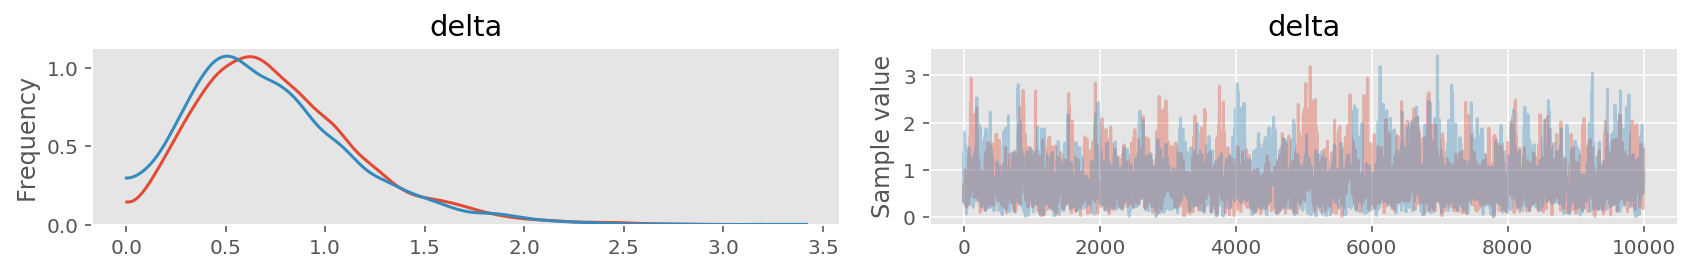


delta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.751            0.422            0.013            [0.003, 1.552]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.115          0.450          0.687          0.982          1.773

the Bayes Factor is 0.12629


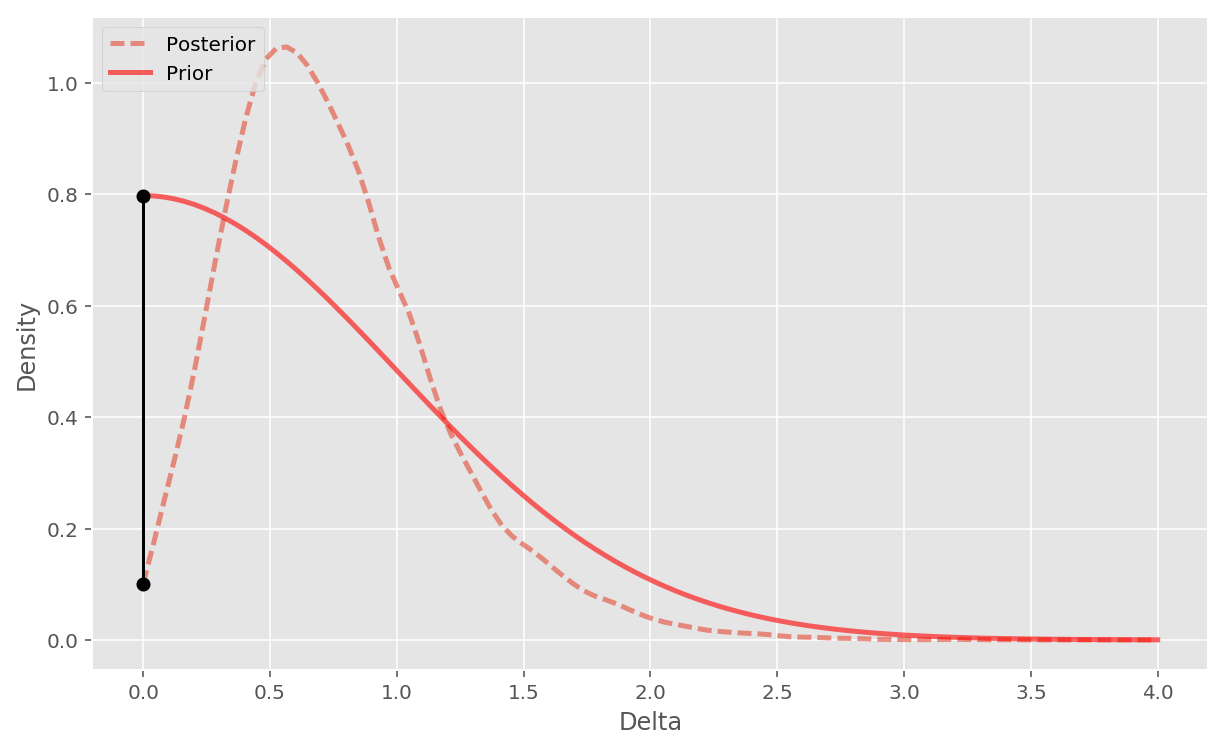

In [19]:
pm.traceplot(trace3[:], varnames=['delta']);
plt.show()
pm.summary(trace3, varnames=['delta'])
tmp = pm.df_summary(trace3, varnames=['delta'])
# 95% confidence interval:
x0 = tmp.values[0, 3]
x1 = tmp.values[0, 4]

fig = plt.figure(figsize=(10, 6)) 
t_delt = trace3['delta'][:]
my_pdf = gaussian_kde(t_delt)
x = np.linspace(0, 4, 100)
plt.plot(x, my_pdf(x), '--', lw=2.5, alpha=0.6, label='Posterior') # distribution function
plt.plot(x, stats.norm.pdf(x)*2, 'r-', lw=2.5, alpha=0.6, label='Prior')
posterior = my_pdf(0)             # this gives the pdf at point delta = 0
prior     = stats.norm.pdf(0)*2         # height of order-restricted prior at delta = 0
BF01      = posterior/prior
print ('the Bayes Factor is %.5f' %(BF01))
plt.plot([0, 0], [posterior, prior], 'k-', 
         [0, 0], [posterior, prior], 'ko', 
         lw=1.5, alpha=1)
plt.xlabel('Delta')
plt.ylabel('Density')
plt.legend(loc='upper left')
plt.show()

## 9.4 Comparing between-subject proportions


$$ \delta \sim \text{Gaussian}(0,1)$$
$$ \mu \sim \text{Gaussian}(0,1)$$
$$ \sigma \sim \text{Uniform}(0,10)$$
$$ \alpha = \delta\sigma$$
  
$$ \phi^c_{i} \sim \text{Gaussian}(\mu\,+\alpha/2,1/\sigma^2)$$
$$ \phi^a_{j} \sim \text{Gaussian}(\mu\,-\alpha/2,1/\sigma^2)$$
  
$$ \theta^c_{i} = \Phi(\phi^c_{i})$$
$$ \theta^a_{j} = \Phi(\phi^a_{j})$$
  
$$ s^c_{i} \sim \text{Binomial}(\theta^c_{i},n^c_{i})$$
$$ s^a_{j} \sim \text{Binomial}(\theta^a_{j},n^a_{j})$$

In [20]:
### Geurts data:
# Normal Controls:         
numerrors1 = np.array([15,10,61,11,60,44,63,70,57,11,67,21,89,12,63,11,96,10,37,19,44,
                18,78,27,60,14])
nc         = np.array([89,74,128,87,128,121,128,128,128,78,128,106,128,83,128,100,128,
                73,128,86,128,86,128,100,128,79])
kc         = nc - numerrors1
nsc        = len(kc)
# ADHD:
numerrors2 = np.array([88,50,58,17,40,18,21,50,21,69,19,29,11,76,46,36,37,72,27,92,13,
                39,53,31,49,57,17,10,12,21,39,43,49,17,39,13,68,24,21,27,48,54,
                41,75,38,76,21,41,61,24,28,21])
na         = np.array([128,128,128,86,128,117,89,128,110,128,93,107,87,128,128,113,128,
                128,98,128,93,116,128,116,128,128,93,86,86,96,128,128,128,86,128,
                78,128,111,100,95,128,128,128,128,128,128,98,127,128,93,110,96])
ka         = na - numerrors2
nsa        = len(ka)

# two-sided p-value = .72
stats.ttest_ind(kc/nc,ka/na,equal_var=False)

Ttest_indResult(statistic=-0.36711531382233059, pvalue=0.71545831925014036)

In [21]:
with pm.Model() as model4:
    delta = pm.Normal('delta', mu=0, sd=1)
    mu_   = pm.Normal('mu', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    alpha = delta*sigma
    
    phic  = pm.Normal('phic', mu=mu_+alpha/2, tau=1/sigma**2, shape=nsc)
    phia  = pm.Normal('phia', mu=mu_-alpha/2, tau=1/sigma**2, shape=nsa)
    
    def Phi(x):
        #'Cumulative distribution function for the standard normal distribution'
        # Also it is the probit transform 
        return (1.0 + tt.erf(x / tt.sqrt(2.0))) / 2.0
    thetac = pm.Deterministic('thetac', Phi(phic))
    thetaa = pm.Deterministic('thetaa', Phi(phia))
    
    kco = pm.Binomial('kco', p=thetac, n=nc, observed=kc)
    kao = pm.Binomial('kao', p=thetaa, n=na, observed=ka)
    
    trace4 = pm.sample(3e3, njobs=2)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -339.55: 100%|██████████| 200000/200000 [00:18<00:00, 10654.96it/s]
Finished [100%]: Average ELBO = -339.55
100%|██████████| 3000/3000.0 [00:08<00:00, 336.99it/s]


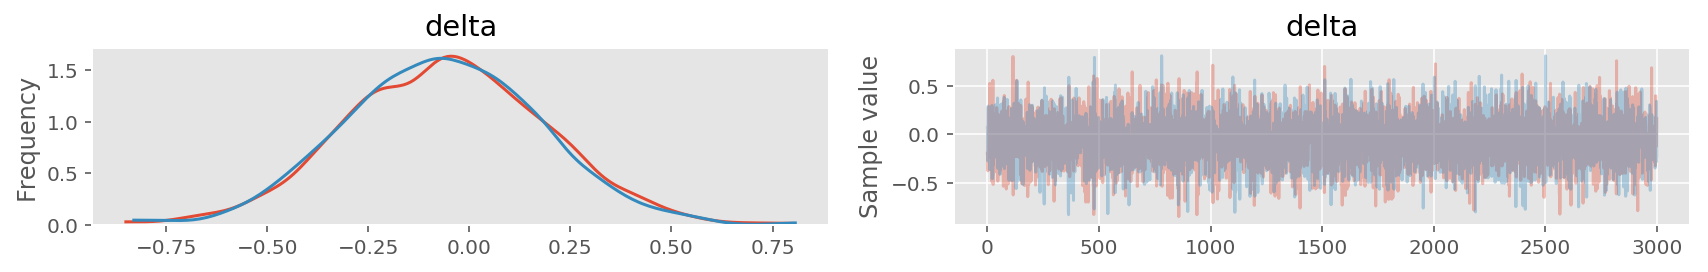


delta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -0.064           0.242            0.002            [-0.538, 0.403]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.529         -0.230         -0.065         0.099          0.413

the Bayes Factor is 3.93005


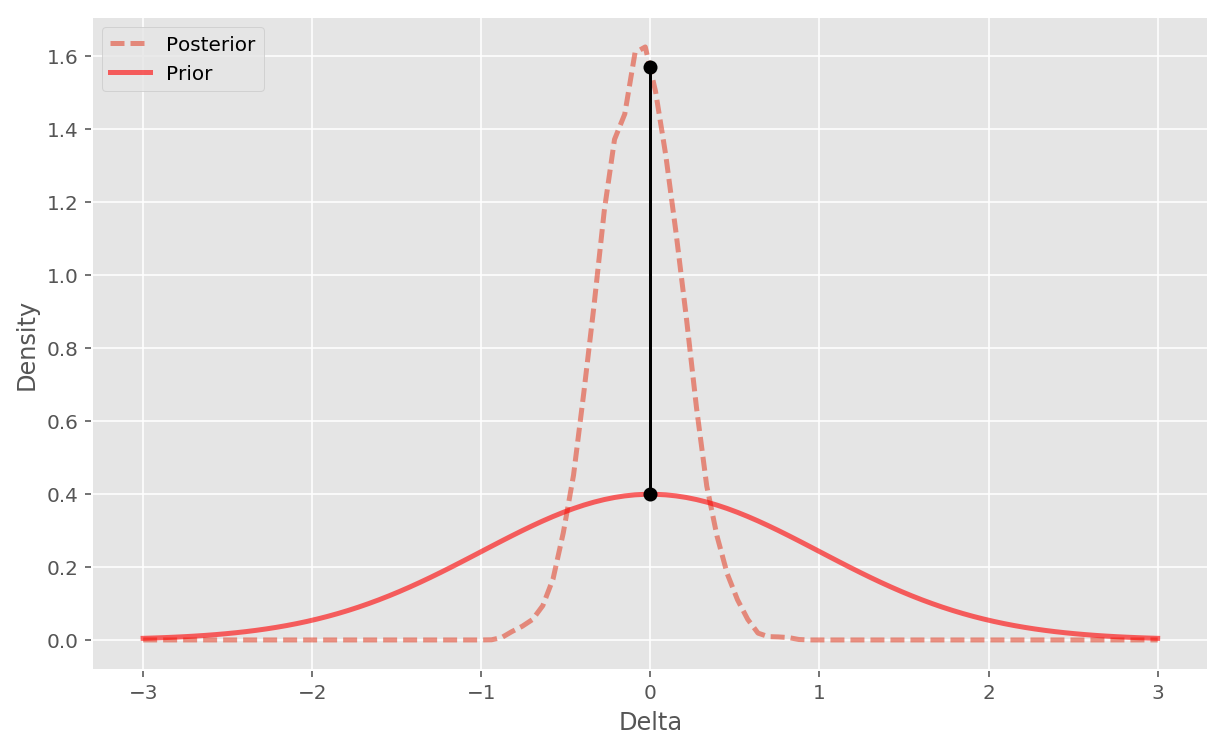

In [22]:
pm.traceplot(trace4[:], varnames=['delta']);
plt.show()
pm.summary(trace4, varnames=['delta'])
tmp = pm.df_summary(trace4, varnames=['delta'])
# 95% confidence interval:
x0 = tmp.values[0, 3]
x1 = tmp.values[0, 4]

fig = plt.figure(figsize=(10, 6)) 
t_delt = trace4['delta'][:]
my_pdf = gaussian_kde(t_delt)
x = np.linspace(-3, 3, 100)
plt.plot(x, my_pdf(x), '--', lw=2.5, alpha=0.6, label='Posterior') # distribution function
plt.plot(x, stats.norm.pdf(x), 'r-', lw=2.5, alpha=0.6, label='Prior')
posterior = my_pdf(0)             # this gives the pdf at point delta = 0
prior     = stats.norm.pdf(0)         # height of order-restricted prior at delta = 0
BF01      = posterior/prior
print ('the Bayes Factor is %.5f' %(BF01))
plt.plot([0, 0], [posterior, prior], 'k-', 
         [0, 0], [posterior, prior], 'ko', 
         lw=1.5, alpha=1)
plt.xlabel('Delta')
plt.ylabel('Density')
plt.legend(loc='upper left')
plt.show()

## 9.5 Order-restricted between-subject proportions


$$ \delta \sim \text{Gaussian}(0,1)_{\mathcal I(0,∞)}$$
$$ \mu \sim \text{Gaussian}(0,1)$$
$$ \sigma \sim \text{Uniform}(0,10)$$
$$ \alpha = \delta\sigma$$
  
$$ \phi^c_{i} \sim \text{Gaussian}(\mu\,+\alpha/2,1/\sigma^2)$$
$$ \phi^a_{j} \sim \text{Gaussian}(\mu\,-\alpha/2,1/\sigma^2)$$
  
$$ \theta^c_{i} = \Phi(\phi^c_{i})$$
$$ \theta^a_{j} = \Phi(\phi^a_{j})$$
  
$$ s^c_{i} \sim \text{Binomial}(\theta^c_{i},n^c_{i})$$
$$ s^a_{j} \sim \text{Binomial}(\theta^a_{j},n^a_{j})$$

In [ ]:
with pm.Model() as model5:
    delta = pm.HalfNormal('delta', sd=1)
    mu_   = pm.Normal('mu', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    alpha = delta*sigma
    
    phic  = pm.Normal('phic', mu=mu_+alpha/2, sd=sigma, shape=nsc)
    phia  = pm.Normal('phia', mu=mu_-alpha/2, sd=sigma, shape=nsa)
    
    def Phi(x):
        #'Cumulative distribution function for the standard normal distribution'
        # Also it is the probit transform 
        return (1.0 + tt.erf(x / tt.sqrt(2.0))) / 2.0
    thetac = pm.Deterministic('thetac', Phi(phic))
    thetaa = pm.Deterministic('thetaa', Phi(phia))
    
    kco = pm.Binomial('kco', p=thetac, n=nc, observed=kc)
    kao = pm.Binomial('kao', p=thetaa, n=na, observed=ka)
    
    trace5 = pm.sample(3e3, njobs=2)

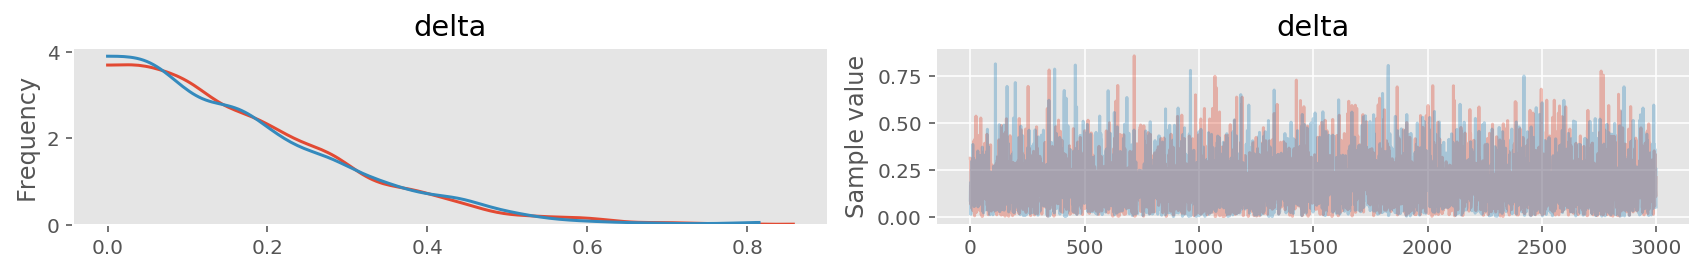


delta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.174            0.137            0.002            [0.000, 0.440]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.007          0.065          0.144          0.252          0.507

the Bayes Factor is  2.36882


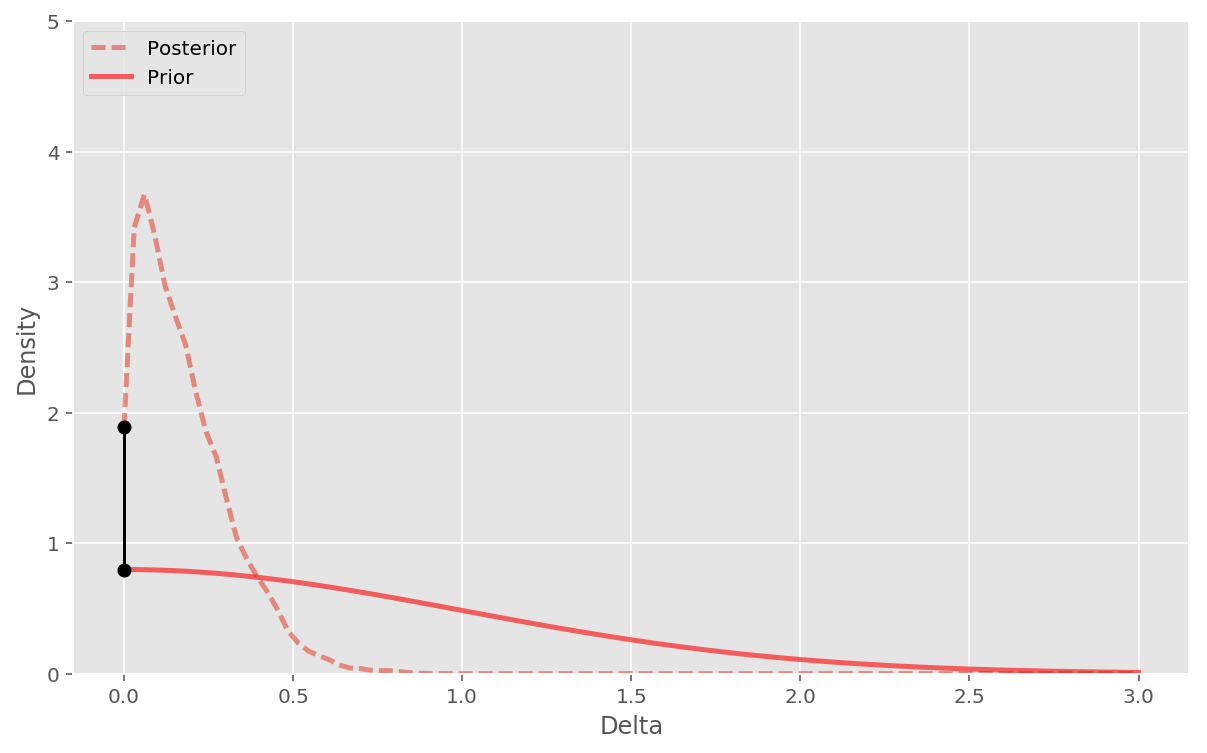

In [25]:
pm.traceplot(trace5[:], varnames=['delta']);
plt.show()
pm.summary(trace5, varnames=['delta'])
tmp = pm.df_summary(trace5, varnames=['delta'])
# 95% confidence interval:
x0 = tmp.values[0, 3]
x1 = tmp.values[0, 4]

fig = plt.figure(figsize=(10, 6)) 
t_delt = trace5['delta'][:]
my_pdf = gaussian_kde(t_delt)

x = np.linspace(0, 3, 100)
plt.plot(x, my_pdf(x), '--', lw=2.5, alpha=0.6, label='Posterior') # distribution function
plt.plot(x, stats.norm.pdf(x)*2,'r-', lw=2.5, alpha=0.6, label='Prior')
posterior = my_pdf(0)             # this gives the pdf at point delta = 0
prior     = stats.norm.pdf(0)*2         # height of order-restricted prior at delta = 0
BF01      = posterior/prior
print ('the Bayes Factor is  %.5f' %(BF01))
plt.plot([0, 0], [posterior, prior], 'k-', 
         [0, 0], [posterior, prior], 'ko',
         lw=1.5, alpha=1)
plt.xlabel('Delta')
plt.ylabel('Density')
plt.legend(loc='upper left')
plt.ylim([0,5])
plt.show()